# Reduced equations for linear bending waves

The name "reduced equations for linear bending waves" comes from Lubow+Ogilvie 2000; it refers A53-54 in Lubow+Ogilvie 2000 and B16-17 in Fairbairn 2025. This pair of coupled PDEs relates the tilt $\mathcal{W}$ and internal torque $\mathcal{G}$:

$$    \frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G  $$
$$ \Sigma \Omega R^2  \frac{\partial \mathcal{W}}{\partial t} = \frac{1}R \frac{\partial \mathcal{G}}{\partial R} $$

## Adding one or more planets

If we insert one planet at the disk's inner boundary and one at the disk's outer boundary, can we reproduce Jiaru's results from using fixed (i.e., Dirichlet) boundary conditions? This requires adding one or more quadrupole torque densities $T$ to the second PDE. 

Following Lubow+Ogilvie 2000, in the rotating binary frame (and assuming the planet is located on the positive x-axis), we have
$$\vec{T} = -\frac{GM_p}{2a^2} \left[ b^{(1)}_{3/2} \left(\frac{r}a \right) \right] \Sigma r \ell_x \hat{y}.$$

For simplicity, I'll first try $\vec{T} = B(r)\ell_x \hat{y} = \frac{A}{r^3} \ell_x \hat{y}$, where $A$ is a constant with units (torque * distance).

## Imports and normalizations

In [2]:
# %pip install fipy

import numpy as np
import time
import math
#import scipy.differentiate
import scipy.integrate as integ

import matplotlib.pyplot as plt

In [108]:
cs = 0.02
alpha = 0.001 # 0.001 # 0.019

## Numerical derivatives

In [4]:
def derivative(f, x):
    '''
    Returns first derivative of f(x) with respect to the domain x.

    '''
    
    # return scipy.differentiate.derivative(f, x)

    derivs = np.zeros(shape=f.shape)

    # handle boundaries
    derivs[0] = (f[1] - f[0]) / (x[1] - x[0])
    derivs[-1] = (f[-1] - f[-2]) / (x[-1] - x[-2])

    # central difference method
    for i in range(1, len(x)-1):
        derivs[i] = (f[i+1] - f[i-1]) / (x[i+1] - x[i-1])

    return derivs

## Disk information

Normalizations:
- $R_0 = 1$
- $\Omega_{K,0} = 1$
- $c_s = 0.02$
- $\alpha = 0.019$
- Density profile: $K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2$

### Density profile

In [5]:
def Sigma(Rs):
    '''
    Returns the disk's background surface density profile.
    
    '''
    
    K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
    fgaps = f_gap(Rs, K, R_a, R_b, D_a, D_b)
    
    Sigma0 = 1
    
    return Sigma0 * Rs**(-3/2) / fgaps

def f_gap(Rs, K, R_a, R_b, D_a, D_b):
    '''
    Function that "shapes" the disk gap profile. Used in `sigma` function. 
    R_a and R_b are the locations of the inner and outer gap edges,
    D_a and D_b are the steepness of the edges, and K determines the
    depth of the gap.
    
    '''

    return 1 + (K-1)/2 * \
        (np.tanh((Rs - R_a)/D_a) - np.tanh((Rs - R_b)/D_b))

In [6]:
## check shape of disk profile
#K, R_a, R_b, D_a, D_b = 19, 1, 2, 0.1, 0.2
#plt.plot(Rs_warp, Sigma(Rs_warp))

### Angular frequency and scale height

In [7]:
def OmegaK(Rs):
    '''
    Returns the Keplerian angular velocity profile.

    '''
    OmegaK_0 = 1 # Omega_K at R=R_0
    return OmegaK_0 * Rs**(-3/2)

def scaleHeight(Rs):
    '''
    Returns the disk's scale height profile. We use H = c_sound / Omega_K.

    '''
    return cs / OmegaK(Rs)    

def Omega(Rs):
    '''
    Returns the disk's background angular velocity profile.

    '''

    OmegaKs = OmegaK(Rs)
    rho_mids = Sigma(Rs) / (np.sqrt(2*np.pi) * scaleHeight(Rs))
    
    coeff = np.sqrt(1 + (cs / (Rs*OmegaKs))**2 * derivative(np.log(rho_mids), np.log(Rs)))
    
    return OmegaKs * coeff

## Planet information

In [8]:
def external_torque_coeff(Rs_torque):
    '''
    I define a planet's external torque as 
    T = B(R) * l_x * \hat{y}, where B(R) \propto R^3.
    This function returns B(R).
    
    '''
    
    A = 1e-2
    
    return A * Rs_torque**(-3)

def laplace_coeff_integrand(phi, x):
    '''
    
    This function represents the integrand of the Laplace coefficient formula
    (Eq. 6.67 of Murray & Dermott). We use j=1 and s=3/2. The result is used 
    in the laplace_coeff function.
    
    PARAMETERS
    ----------
    phi: the variable that we integrate over
    x: the variable that isn't integrated over
    
    '''
    
    num = np.cos(phi) # numerator
    denom = (1 - 2 * x * np.cos(phi) + x**2) ** (3/2)
    
    return num / denom

def laplace_coeff(x):
    '''
    
    Calculate the Laplace coefficient using Eq. 6.67 of Murray & Dermott.

    
    PARAMETERS
    ----------
    x: argument of the Laplace coefficient formula
    
    '''
    
    return 2 / np.pi * integ.quad(laplace_coeff_integrand, 0, np.pi, args=(x))[0]

In [9]:
# correctness check: for x >> 1, b ~ 3/x^4
# laplace_coeff(20)

## Integration functions

Boundary conditions:
- $\frac{\partial \mathcal{W}}{\partial R} (R_\text{min}, t) = 0$
- $\frac{\partial \mathcal{W}}{\partial R} (R_\text{max}, t) = 0$

Initial conditions:
- $\mathcal{W}(R_\text{min}, 0) = 0$ 
- $\mathcal{W}(R_\text{max}, 0) = 0.1$ 
- $\mathcal{W}(R,0)$ is some smooth function (eg, Gaussian integral)

In [35]:
def dG_dt(Rs_torque, Gs, Rs_warp, Ws, external_torque):
    '''
    Returns dG/dt over the R domain (Rs_torque) for Gs.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from 1/2 to N-1/2.
    
    `external_torque` determines if we include external torque terms. 

    '''

    # since we're changing G, compute values over G's R domain
    Sigmas = Sigma(Rs_torque) # length N
    Hs = scaleHeight(Rs_torque)
    Omegas = Omega(Rs_torque)
    
    dW_dRs = (Ws[1:] - Ws[:-1]) / (Rs_warp[1:] - Rs_warp[:-1]) # length N

    term1 = Sigmas * (Hs**2) * (Omegas**3) * (Rs_torque**3) / 4 * dW_dRs # sloshing term
    term2 = (-1) * alpha * Omegas * Gs # viscous term
    
    dG_dts = term1 + term2
    
    if external_torque:
        term3 = -1j * Omegas * Gs # from frame transform
        term4 = -1j * (2*Sigmas*Omegas*Rs_torque**2)**(-1) * \
            external_torque_coeff(Rs_torque) * Gs
        dG_dts += (term3 + term4)
    
    return dG_dts

def dW_dt(Rs_torque, Gs, Rs_warp, Ws, external_torque,\
          inner_Neumann, outer_Neumann):
    '''
    Returns dW/dt over the R domain (Rs) for Ws.
    
    Assumes that `Ws` and `Gs` are staggered in the R domain:
    Ws should be indexed from 0 through N, while `Gs` should be indexed
    from 1/2 to N-1/2.
    
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.

    '''

    # since we're changing W, compute values over W's R domain
    Sigmas = Sigma(Rs_warp) # length N+1
    Omegas = Omega(Rs_warp)
    
    # defines dG_dR for indices 1 through N-1
    dG_dRs_middle = (Gs[1:] - Gs[:-1]) / (Rs_torque[1:] - Rs_torque[:-1]) # length N-1
    dG_dRs = np.zeros(shape=Rs_warp.shape, dtype=complex)
    dG_dRs[1:-1] = dG_dRs_middle

    coeff = (Sigmas * Omegas * Rs_warp**3)**(-1)
    
    dW_dts = coeff * dG_dRs
    
    if external_torque:
        term2 = -1j * Sigmas * Rs_warp**2 * Omegas**2 * Ws # from frame transform
        term3 = -1j * external_torque_coeff(Rs_warp) * Ws.real
    
    # ensures dW_dR = 0 at R_min and/or R_max
    if inner_Neumann:
        dW_dts[0] = dW_dts[1]
    if outer_Neumann:
        dW_dts[-1] = dW_dts[-2]
    
    return dW_dts

In [17]:
def evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt, external_torque):
    '''
    Use the predictor-corrector method to evolve G(R) forward by one timestep (dt).
    W and G are staggered in the R domain.
    
    `external_torque` is explained in the documentation for the `integrate` function.

    '''

    # predictor step
    F1 = dG_dt(Rs_torque, Gs, Rs_warp, Ws, external_torque)
    Gprimes = Gs + F1*dt

    # corrector step
    F2 = dG_dt(Rs_torque, Gprimes, Rs_warp, Ws, external_torque)
    Gnexts = Gs + (F1+F2)/2 * dt

    return Gnexts

def evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt, external_torque, \
             inner_Neumann, outer_Neumann):
    '''
    Use the predictor-corrector method to evolve W(R) forward by one timestep (dt).
    W and G are staggered in the R domain.
    
    `external_torque` and `inner/outer_Neumann` are explained in the 
    documentation for the `integrate` function.
    
    '''

    # predictor step
    F1 = dW_dt(Rs_torque, Gs, Rs_warp, Ws, external_torque, \
             inner_Neumann, outer_Neumann)
    Wprimes = Ws + F1*dt

    # corrector step
    F2 = dW_dt(Rs_torque, Gs, Rs_warp, Wprimes, external_torque, \
             inner_Neumann, outer_Neumann)
    Wnexts = Ws + (F1+F2)/2 * dt

    return Wnexts

In [22]:
def integrate(Rs_torque, Gs, Rs_warp, Ws, ts, external_torque=False,\
          inner_Neumann=False, outer_Neumann=False):
    '''

    Integrate W(R) and G(R) over a given time domain (ts). Returns W(R) and 
    G(R) at the final timestep.
    
    W and G are staggered in the R domain.
    
    If `external_torque` is True, include a quadrupole external torque in
    the system.
    
    If `inner_Neumann` is True, ensures that dW_dR=0 at the inner boundary 
    (ie, at R_min). Else, we do not change W at R_min (this is equivalent to 
    a Dirichlet boundary condition).
    The same is true for `outer_Neumann`, except applied to the outer boundary.
    See `dW_dt` function.

    '''

    dts = ts[1:] - ts[:-1]
    
    for dt in dts:
        Gnexts = evolve_G(Rs_torque, Gs, Rs_warp, Ws, dt, external_torque)
        Wnexts = evolve_W(Rs_torque, Gs, Rs_warp, Ws, dt, external_torque, \
             inner_Neumann, outer_Neumann)

        Ws, Gs = Wnexts, Gnexts 

    return Ws, Gs

## Run a sim (no planet)

Note that, from the $\frac{\partial \mathcal{G}}{\partial t} = \frac{\Sigma H^2 \Omega^3 R^3}4 \frac{\partial \mathcal{W}}{\partial R}  - \alpha \Omega G$, we can see that $t \sim \Omega^{-1} h^{-1}$ and $t \sim \Omega^{-1} \alpha^{-1} $ are both relevant timescales. This corresponds to $\sim$10-100 $\Omega^{-1}$.

In [142]:
# spatial and time domains
Rmin = 0.5
Rmax = 3.5
DeltaR = 0.1
num_Rs = (int) ((Rmax - Rmin) / DeltaR) + 1

# stagger W and G in the R domain
Rs_warp = np.linspace(Rmin, Rmax, num_Rs)
Rs_torque = Rs_warp[:-1] + DeltaR/2

tmin = 0
tmax = 8000
Deltat = 0.03
num_ts = (int) ((tmax - tmin) / Deltat) + 1
ts = np.linspace(tmin, tmax, num_ts)

Ws = 0.1 * np.cumsum(np.exp(-(Rs_warp-2)**2 / 2) / np.sqrt(2*np.pi)) * DeltaR
Ws = (Ws + 0.5j*Ws).astype(complex)

#Ws = np.zeros(shape=Rs.shape) + (Rs-0.5)/30 # tilt W(R)
Gs = np.zeros(shape=Rs_torque.shape) # torque G(R)
Gs = Gs.astype(complex)


In [143]:
start = time.time()
Ws_final, Gs_final = integrate(Rs_torque, Gs, Rs_warp, Ws, ts, inner_Neumann=True,\
                              outer_Neumann=False)
## use below line if you want to use a previous sim's results
# Ws_final, Gs_final = integrate(Rs_torque, Gs_final, Rs_warp, Ws_final, ts)
end = time.time()
print("Elapsed time:", np.round(end - start, 2))

<ipython-input-35-a47228afd39d>:58: RuntimeWarning: invalid value encountered in reciprocal
  coeff = (Sigmas * Omegas * Rs_warp**3)**(-1)


Elapsed time: 55.06


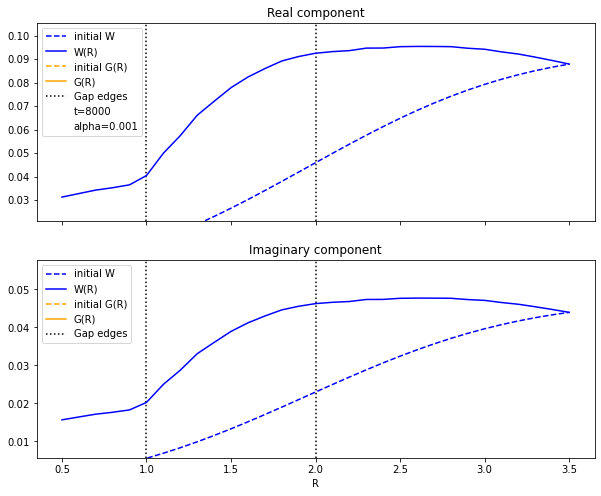

In [151]:
fig, axs = plt.subplots(2, sharex=True, figsize=(10,8))
fig.set_facecolor("white")

axs[0].plot(Rs_warp, Ws.real, c="blue", ls="--", label="initial W")
axs[0].plot(Rs_warp, Ws_final.real, c="blue", label="W(R)")
axs[0].plot(Rs_torque, Gs.real, c="orange", ls="--", label="initial G(R)")
axs[0].plot(Rs_torque, Gs_final.real, c="orange", label="G(R)")

ymin, ymax= min(Ws_final.real) - .01, max(Ws_final.real) + .01
R_a, R_b = 1, 2
axs[0].vlines(R_a, ymin, ymax, color="black", linestyle=":")
axs[0].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

axs[0].set_ylim(ymin,ymax)

axs[0].scatter([],[], s=0, label="t=" + str(tmax))
axs[0].scatter([],[], s=0, label="alpha=" + str(alpha))
axs[0].legend()
axs[0].set_title("Real component")

axs[1].plot(Rs_warp, Ws.imag, c="blue", ls="--", label="initial W")
axs[1].plot(Rs_warp, Ws_final.imag, c="blue", label="W(R)")
axs[1].plot(Rs_torque, Gs.imag, c="orange", ls="--", label="initial G(R)")
axs[1].plot(Rs_torque, Gs_final.imag, c="orange", label="G(R)")

ymin, ymax= min(Ws_final.imag) - .01, max(Ws_final.imag) + .01
R_a, R_b = 1, 2
axs[1].vlines(R_a, ymin, ymax, color="black", linestyle=":")
axs[1].vlines(R_b, ymin, ymax, color="black", linestyle=":", label="Gap edges")

axs[1].set_ylim(ymin,ymax)

axs[1].legend()
axs[1].set_title("Imaginary component")

axs[1].set_xlabel("R")

plt.show()

### Compare to steady-state solution

In [105]:
# check that, if Neumann conditions are on, W changes at boundaries
# print(Ws[0] - Ws_final[0])
# print(Ws[-1] - Ws_final[-1])

In [141]:
# Gs_final[-1] - Gs_final[0]

In [140]:
# plt.plot(Gs_final)

/Users/jupiterding/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/Users/jupiterding/miniconda3/lib/python3.9/site-packages/matplotlib/cbook/__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


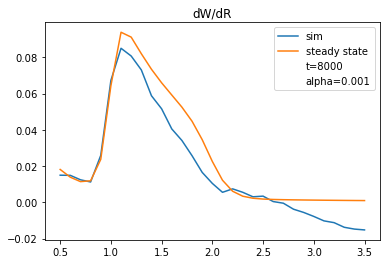

In [149]:
def dW_dR_ss_coeff(Rs):
    '''
    Coefficient for the steady-state value of dW/dR (see below).
    Assumes no external torque.
    
    '''
    
    return Sigma(Rs) * scaleHeight(Rs)**2 * Omega(Rs)**3 * Rs**3 / 4


fig = plt.figure()
fig.set_facecolor("white")

plt.plot(Rs_warp, np.gradient(Ws_final, Rs_warp), label="sim")
# in steady-state, G should be constant
plt.plot(Rs_warp, alpha * Omega(Rs_warp) * Gs_final[-1] \
         / dW_dR_ss_coeff(Rs_warp), label="steady state")

plt.scatter([],[], s=0, label="t=" + str(tmax))
plt.scatter([],[], s=0, label="alpha=" + str(alpha))

plt.title("dW/dR")
plt.legend()